Station popularity (using trip count)

In [10]:
pip install kaleido

Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd

# Load your trip data with community information
file_path = 'Data/Processed data/trip_data_with_communities.csv'  # Update this path if needed
df = pd.read_csv(file_path)

# Calculate the number of trips where each station was the starting point
start_counts = df['Start station'].value_counts().reset_index()
start_counts.columns = ['Station', 'Start Count']

# Count the number of trips where each station was the ending point
end_counts = df['End station'].value_counts().reset_index()
end_counts.columns = ['Station', 'End Count']

# Merge the counts into a single DataFrame
station_trip_counts = pd.merge(start_counts, end_counts, on='Station', how='outer')

# Fill any NaN values with 0 (in case a station only appears as either start or end point)
station_trip_counts = station_trip_counts.fillna(0)

# Calculate the total trips involving each station
station_trip_counts['Total Trips'] = station_trip_counts['Start Count'] + station_trip_counts['End Count']

# Calculate the Start/End ratio
station_trip_counts['Start/End'] = station_trip_counts['Start Count'] / station_trip_counts['End Count']

# Merge community information back into the trip counts dataset
# Use the 'Start station' and 'Community_start' columns for the merge
station_communities = df[['Start station', 'Community_start']].drop_duplicates().rename(
    columns={'Start station': 'Station', 'Community_start': 'Community'})

# Merge with the trip counts
station_trip_counts = pd.merge(station_trip_counts, station_communities, on='Station', how='left')

# Display the merged dataset
print(station_trip_counts)

# Optionally, save the result to a CSV file
station_trip_counts.to_csv('Data/Results/station_trip_counts_with_communities.csv', index=False)


                               Station  Start Count  End Count  Total Trips  \
0    Abbey Orchard Street, Westminster          498        575         1073   
1          Abingdon Green, Westminster          418        427          845   
2     Albany Street, The Regent's Park          492        416          908   
3          Albert Embankment, Vauxhall          309        244          553   
4               Albert Gate, Hyde Park          718        585         1303   
..                                 ...          ...        ...          ...   
365             Wood Street, Guildhall          403        516          919   
366          Woodstock Street, Mayfair          234        232          466   
367  Wormwood Street, Liverpool Street         2290       2171         4461   
368         Worship Street, Shoreditch          692        725         1417   
369               Wren Street, Holborn          622        609         1231   

     Start/End  Community  
0     0.866087         

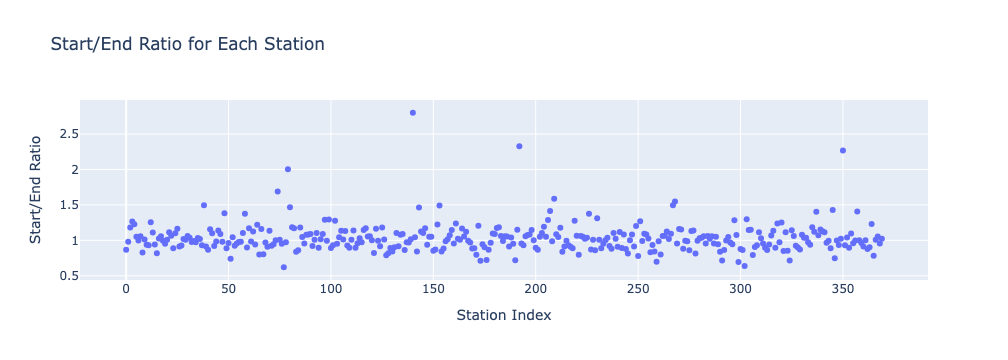

In [15]:
import pandas as pd
import plotly.express as px

# Load your data
file_path = 'Data/Results/station_trip_counts_with_communities.csv'
df = pd.read_csv(file_path)

# Assuming station_trip_counts is your DataFrame with the 'Start/End' column
station_trip_counts = df  # Replace with your actual DataFrame if different

# Create the interactive scatter plot
fig = px.scatter(
    station_trip_counts,
    x=range(len(station_trip_counts)),  # X-axis as the index of stations
    y='Start/End',                      # Y-axis as the Start/End ratio
    hover_name='Station',               # The station name will be shown on hover
    title='Start/End Ratio for Each Station',
    labels={'x': 'Station Index', 'Start/End': 'Start/End Ratio'},
    hover_data={'Start Count': True, 'End Count': True, 'Total Trips': True},  # More info on hover
)

# Show the plot
fig.show()

# Save the plot as an HTML file
fig.write_html('Data/Results/start_end_ratio_for_each_station.html')


# # Save the plot as a PDF file
# fig.write_image('start_end_ratio_for_each_station.pdf')

Looking at communities

In [16]:
import pandas as pd

file_path = 'Data/Results/station_trip_counts_with_communities.csv'
df = pd.read_csv(file_path)

# Group by the start community and sum the trip counts
community_trip_counts = station_trip_counts.groupby('Community').agg({
    'Start Count': 'sum',
    'End Count': 'sum',
    'Total Trips': 'sum'
}).reset_index()

# Calculate the Start/End ratio for each community
community_trip_counts['Start/End'] = community_trip_counts['Start Count'] / community_trip_counts['End Count']

# Sort by total trips or Start/End ratio for analysis
community_trip_counts_sorted = community_trip_counts.sort_values(by='Total Trips', ascending=False)

# Display the community-level data
print(community_trip_counts_sorted)


   Community  Start Count  End Count  Total Trips  Start/End
1          1        65483      64135       129618   1.021018
0          0        61279      59554       120833   1.028965
2          2        51615      53526       105141   0.964298
3          3        33200      34362        67562   0.966184


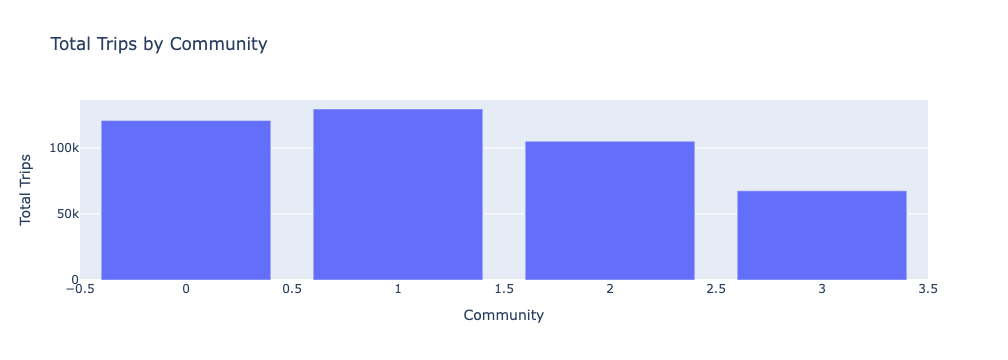

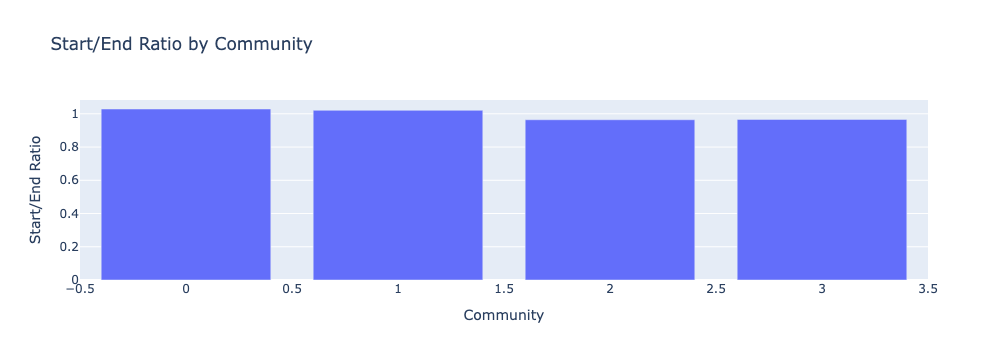

In [17]:
import plotly.express as px
import pandas as pd

file_path = 'Data/Results/station_trip_counts_with_communities.csv'
df = pd.read_csv(file_path)
# Create a bar plot for total trips by community
fig = px.bar(
    community_trip_counts_sorted,
    x='Community', 
    y='Total Trips',
    title='Total Trips by Community',
    labels={'Community': 'Community', 'Total Trips': 'Total Trips'},
    hover_data={'Start Count': True, 'End Count': True, 'Start/End': True}
)
fig.show()
# Save the plot as an HTML file
fig.write_html('Data/Results/Total_trips_per_community.html')

# Create a bar plot for Start/End ratio by community
fig = px.bar(
    community_trip_counts_sorted,
    x='Community',
    y='Start/End',
    title='Start/End Ratio by Community',
    labels={'Community': 'Community', 'Start/End': 'Start/End Ratio'},
    hover_data={'Start Count': True, 'End Count': True, 'Total Trips': True}
)
fig.show()
# Save the plot as an HTML file
fig.write_html('Data/Results/start_end_ratio_for_each_community.html')


In [19]:
df = pd.read_csv('Data/Processed data/trip_data_with_communities.csv')

# Create a pivot table to see trips between communities
inter_community_trips = df.pivot_table(
    index='Community_start',
    columns='Community_end',
    values='Number',  # Or use any other metric, like Total Trips
    aggfunc='count',
    fill_value=0
)

print(inter_community_trips)


Community_end        0      1      2      3
Community_start                            
0                34559  11317   7050   8353
1                11539  36599  13284   4061
2                 6119  12367  27563   5566
3                 7337   3852   5629  16382


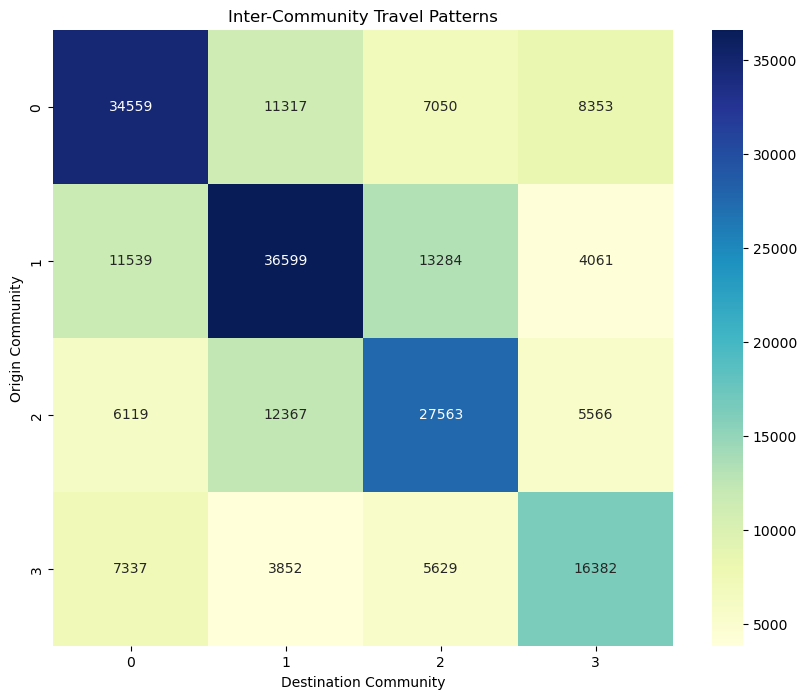

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot a heatmap for the inter-community travel patterns
plt.figure(figsize=(10, 8))
sns.heatmap(inter_community_trips, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Inter-Community Travel Patterns')
plt.xlabel('Destination Community')
plt.ylabel('Origin Community')

# Save the plot to a file before showing it
plt.savefig('Data/Results/Inter-community_travel_patterns.png')

# Show the plot
plt.show()
